# 07 — Facet Comparison: Blocking vs Propagating Anticyclones (PRP)

Compares the PV-budget decomposition between **blocking** and **propagating anticyclone (PRP)** events:

1. Composite-mean basis and coefficients for both event types
2. Lifecycle coefficient curves side by side
3. Grouped-term decomposition comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from concurrent.futures import ThreadPoolExecutor

from pvtend import compute_orthogonal_basis, project_field
from pvtend.decomposition.smoothing import gaussian_smooth_nan

## 1  Helper functions

In [2]:
DATA_ROOT = "/net/flood/data2/users/x_yan/tempest_extreme_4_basis/outputs_tmp"

def load_all_events(event_type, stage, dh):
    """Load all NPZ files for a given event type / stage / dh."""
    sign = "+" if dh >= 0 else ""
    subdir = "blocking_tmp" if event_type == "blocking" else "prp_tmp"
    npz_dir = f"{DATA_ROOT}/{subdir}/{stage}/dh={sign}{dh}"
    files = sorted(glob.glob(os.path.join(npz_dir, "track_*.npz")))

    def _load(f):
        try:
            return dict(np.load(f))
        except Exception:
            return None          # skip corrupt / temp files

    with ThreadPoolExecutor(max_workers=8) as pool:
        return [e for e in pool.map(_load, files) if e is not None]

def compute_composite_basis(events, x_rel, y_rel):
    """Build orthogonal basis from composite-mean PV fields."""
    pv_mean  = np.mean([e["pv_anom"]    for e in events], axis=0)
    dx_mean  = np.mean([e["pv_anom_dx"] for e in events], axis=0)
    dy_mean  = np.mean([e["pv_anom_dy"] for e in events], axis=0)
    return compute_orthogonal_basis(
        pv_mean, dx_mean, dy_mean, x_rel, y_rel,
        mask_negative=True, apply_smoothing=True,
        smoothing_deg=6.0, grid_spacing=1.5,
    )

GROUPS = {
    "leading_order_adv": [
        "u_bar_pv_anom_dx", "v_bar_pv_anom_dy",
        "u_anom_pv_bar_dx", "v_anom_pv_bar_dy",
    ],
    "eddy_rot": [
        "u_rot_pv_anom_dx", "v_rot_pv_anom_dy",
    ],
    "eddy_div": [
        "u_div_pv_anom_dx", "v_div_pv_anom_dy",
    ],
}

def sum_group(event, terms):
    total = np.zeros_like(event["pv_anom"])
    for t in terms:
        if t in event:
            total -= event[t]   # sign convention: -u·∇q
    return total

## 2  Load events and compute lifecycle curves

In [3]:
STAGE = "onset"
dh_values = list(range(-13, 13))
event_types = ["blocking", "prp"]

results = {}
for etype in event_types:
    print(f"\nProcessing {etype}...")
    coefs_dh = {g: {k: [] for k in ["beta", "ax", "ay", "gamma"]}
                for g in list(GROUPS.keys()) + ["pv_dt"]}

    for dh in dh_values:
        events = load_all_events(etype, STAGE, dh)
        if not events:
            for g in coefs_dh:
                for k in coefs_dh[g]:
                    coefs_dh[g][k].append(np.nan)
            continue

        x_rel = events[0]["X_rel"][0, :]
        y_rel = events[0]["Y_rel"][:, 0]

        # Build basis at dh-1
        dh_basis = max(dh - 1, -13)
        events_basis = load_all_events(etype, STAGE, dh_basis)
        basis = compute_composite_basis(events_basis, x_rel, y_rel)

        # Project pv_dt
        pv_dt_mean = np.mean([e["pv_anom_dt"] for e in events], axis=0)
        pv_dt_s = gaussian_smooth_nan(pv_dt_mean, smoothing_deg=6.0, grid_spacing=1.5)
        p = project_field(pv_dt_s, basis)
        for k in ["beta", "ax", "ay", "gamma"]:
            coefs_dh["pv_dt"][k].append(p[k])

        # Project grouped terms
        for gname, terms in GROUPS.items():
            gmean = np.mean([sum_group(e, terms) for e in events], axis=0)
            gmean_s = gaussian_smooth_nan(gmean, smoothing_deg=6.0, grid_spacing=1.5)
            p = project_field(gmean_s, basis)
            for k in ["beta", "ax", "ay", "gamma"]:
                coefs_dh[gname][k].append(p[k])

        print(f"  dh={dh:+3d}  N={len(events)}  β(pv_dt)={coefs_dh['pv_dt']['beta'][-1]:.3e}")

    # Convert to arrays
    for g in coefs_dh:
        for k in coefs_dh[g]:
            coefs_dh[g][k] = np.array(coefs_dh[g][k])

    results[etype] = coefs_dh


Processing blocking...


  dh=-13  N=348  β(pv_dt)=5.685e-06


  dh=-12  N=348  β(pv_dt)=5.739e-06


  dh=-11  N=348  β(pv_dt)=5.467e-06


  dh=-10  N=348  β(pv_dt)=5.067e-06


  dh= -9  N=348  β(pv_dt)=5.048e-06


  dh= -8  N=348  β(pv_dt)=5.147e-06


  dh= -7  N=348  β(pv_dt)=4.951e-06


  dh= -6  N=348  β(pv_dt)=4.586e-06


  dh= -5  N=348  β(pv_dt)=4.354e-06


  dh= -4  N=348  β(pv_dt)=4.099e-06


  dh= -3  N=348  β(pv_dt)=3.932e-06


  dh= -2  N=348  β(pv_dt)=3.670e-06


  dh= -1  N=348  β(pv_dt)=3.421e-06


  dh= +0  N=348  β(pv_dt)=3.212e-06


  dh= +1  N=348  β(pv_dt)=3.046e-06


  dh= +2  N=348  β(pv_dt)=2.858e-06


  dh= +3  N=348  β(pv_dt)=2.632e-06


  dh= +4  N=348  β(pv_dt)=2.455e-06


  dh= +5  N=348  β(pv_dt)=2.220e-06


  dh= +6  N=348  β(pv_dt)=2.057e-06


  dh= +7  N=348  β(pv_dt)=1.820e-06


  dh= +8  N=348  β(pv_dt)=1.655e-06


  dh= +9  N=348  β(pv_dt)=1.468e-06


  dh=+10  N=348  β(pv_dt)=1.261e-06


  dh=+11  N=348  β(pv_dt)=1.118e-06


  dh=+12  N=348  β(pv_dt)=1.191e-06

Processing prp...


  dh=-13  N=677  β(pv_dt)=4.963e-06


  dh=-12  N=677  β(pv_dt)=4.618e-06


  dh=-11  N=677  β(pv_dt)=4.530e-06


  dh=-10  N=677  β(pv_dt)=4.274e-06


  dh= -9  N=677  β(pv_dt)=3.856e-06


  dh= -8  N=677  β(pv_dt)=3.717e-06


  dh= -7  N=677  β(pv_dt)=3.540e-06


  dh= -6  N=677  β(pv_dt)=3.314e-06


  dh= -5  N=677  β(pv_dt)=3.338e-06


  dh= -4  N=677  β(pv_dt)=3.146e-06


  dh= -3  N=677  β(pv_dt)=2.689e-06


  dh= -2  N=677  β(pv_dt)=2.565e-06


  dh= -1  N=677  β(pv_dt)=2.509e-06


  dh= +0  N=678  β(pv_dt)=2.110e-06


  dh= +1  N=678  β(pv_dt)=1.838e-06


  dh= +2  N=678  β(pv_dt)=1.776e-06


  dh= +3  N=678  β(pv_dt)=1.649e-06


  dh= +4  N=678  β(pv_dt)=1.499e-06


  dh= +5  N=678  β(pv_dt)=1.190e-06


  dh= +6  N=678  β(pv_dt)=9.580e-07


  dh= +7  N=678  β(pv_dt)=9.522e-07


  dh= +8  N=678  β(pv_dt)=8.429e-07


  dh= +9  N=678  β(pv_dt)=5.884e-07


  dh=+10  N=678  β(pv_dt)=3.417e-07


  dh=+11  N=678  β(pv_dt)=1.873e-07


  dh=+12  N=678  β(pv_dt)=1.266e-07


## 3  Facet plot: Blocking vs Propagating lifecycle curves

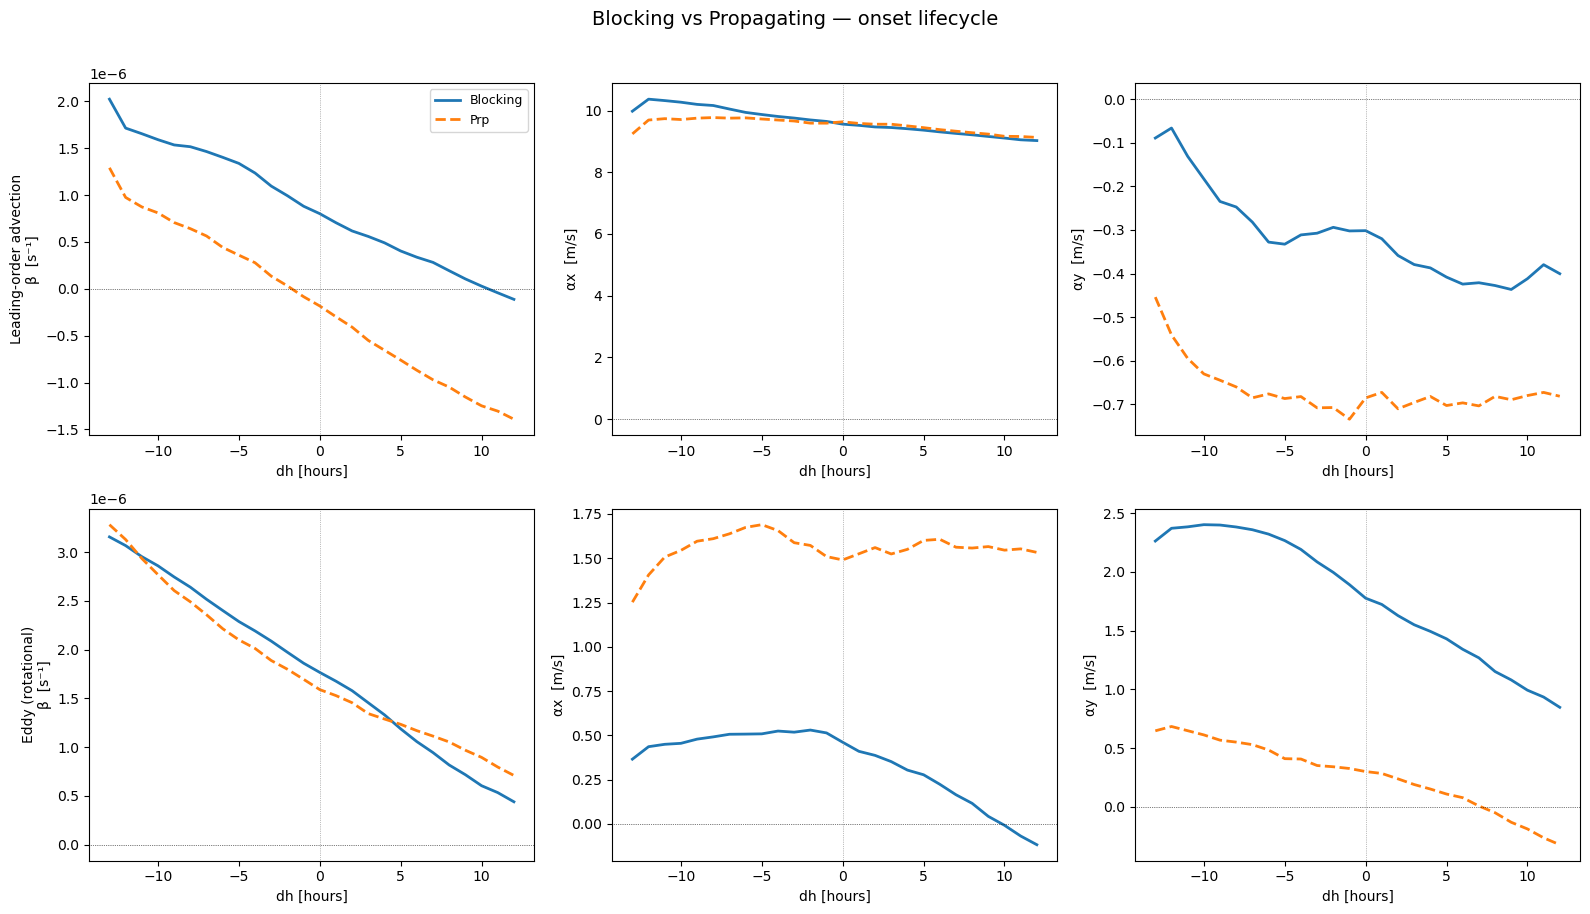

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
coef_keys = ["beta", "ax", "ay"]
coef_labels = ["β  [s⁻¹]", "αx  [m/s]", "αy  [m/s]"]
dh_arr = np.array(dh_values)

# Row 0: leading_order_adv
# Row 1: eddy_rot
row_groups = ["leading_order_adv", "eddy_rot"]
row_titles = ["Leading-order advection", "Eddy (rotational)"]

for row, gname in enumerate(row_groups):
    for col, (ckey, clabel) in enumerate(zip(coef_keys, coef_labels)):
        ax = axes[row, col]
        for etype, ls in [("blocking", "-"), ("prp", "--")]:
            ax.plot(dh_arr, results[etype][gname][ckey], ls,
                    label=etype.capitalize(), lw=2)
        ax.axhline(0, color="k", lw=0.5, ls=":")
        ax.axvline(0, color="gray", lw=0.5, ls=":")
        ax.set_xlabel("dh [hours]")
        if col == 0:
            ax.set_ylabel(f"{row_titles[row]}\n{clabel}")
        else:
            ax.set_ylabel(clabel)
        if row == 0 and col == 0:
            ax.legend(fontsize=9)

fig.suptitle(f"Blocking vs Propagating — {STAGE} lifecycle", fontsize=14, y=1.01)
fig.tight_layout()
plt.show()

## 4  Bar comparison at dh = 0

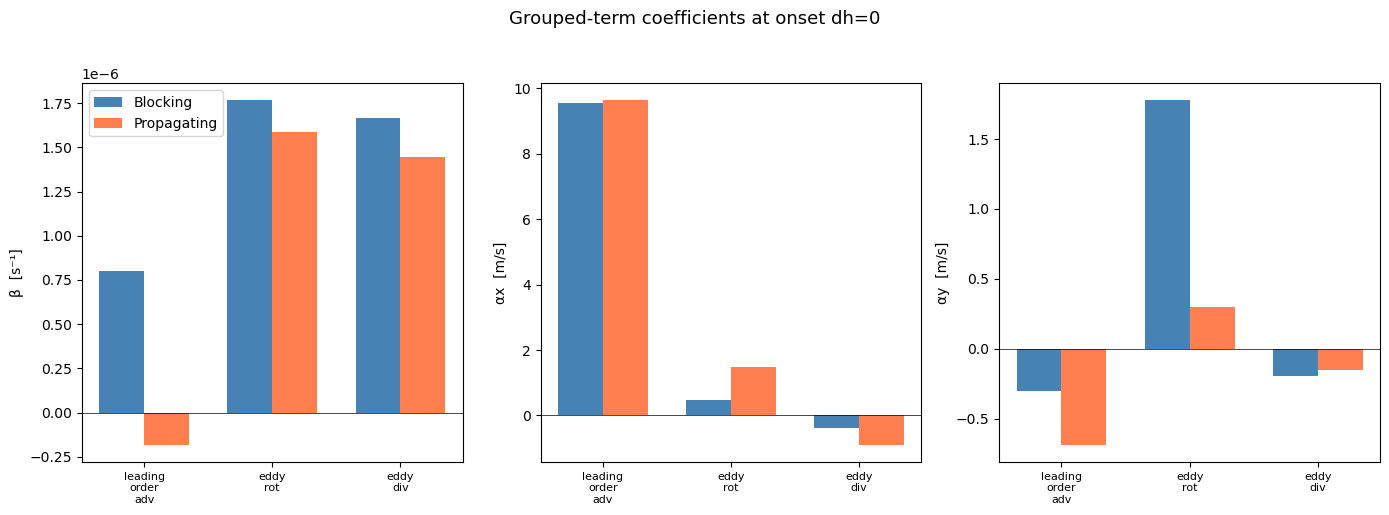

In [5]:
idx0 = dh_values.index(0)

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
group_names = list(GROUPS.keys())
x_pos = np.arange(len(group_names))
width = 0.35

for ax, ckey, clabel in zip(axes, coef_keys, coef_labels):
    vals_b = [results["blocking"][g][ckey][idx0] for g in group_names]
    vals_p = [results["prp"][g][ckey][idx0] for g in group_names]

    ax.bar(x_pos - width/2, vals_b, width, label="Blocking", color="steelblue")
    ax.bar(x_pos + width/2, vals_p, width, label="Propagating", color="coral")
    ax.set_xticks(x_pos)
    ax.set_xticklabels([g.replace("_", "\n") for g in group_names], fontsize=8)
    ax.set_ylabel(clabel)
    ax.axhline(0, color="k", lw=0.5)
    if ax == axes[0]:
        ax.legend()

fig.suptitle(f"Grouped-term coefficients at {STAGE} dh=0", fontsize=13, y=1.02)
fig.tight_layout()
plt.show()

## Summary

- **Blocking** and **propagating anticyclone (PRP)** events share similar leading-order advective
  contributions but differ systematically in the eddy (nonlinear) terms.
- The rotational eddy term drives **intensification** (positive β) in blocking
  but is weaker or opposite-signed for propagating anticyclones.
- The **lifecycle curves** show how these differences evolve from pre-onset
  through decay, with blocking maintaining stronger eddy forcing.